matrice singuliere


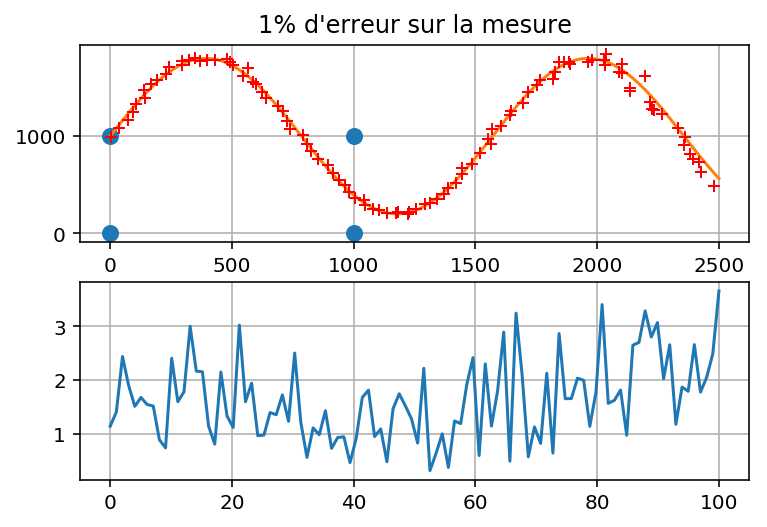

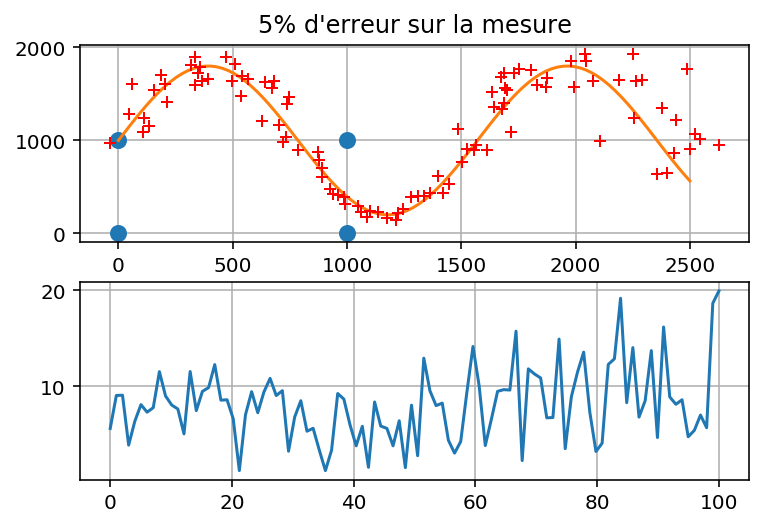

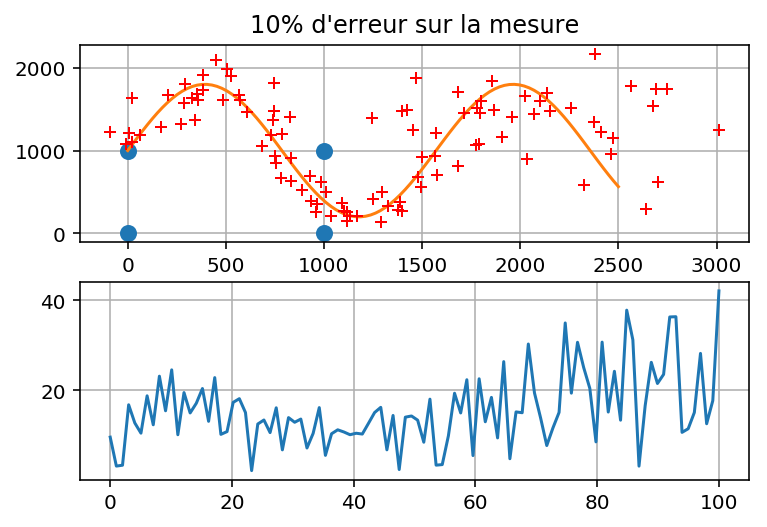

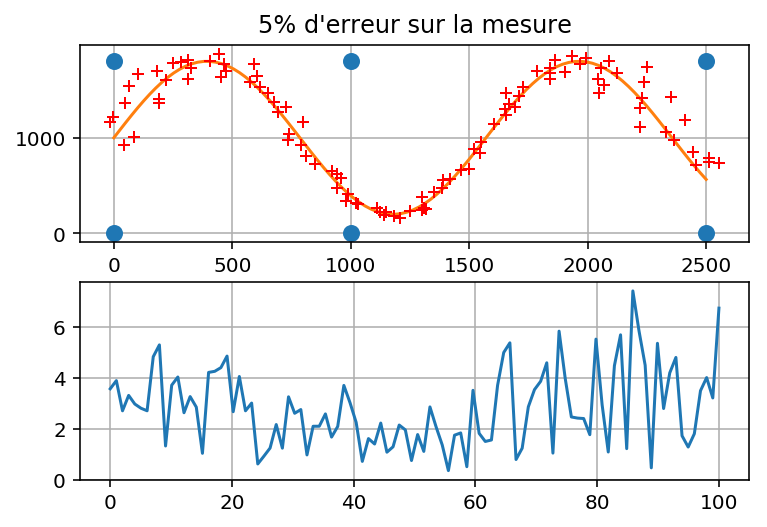

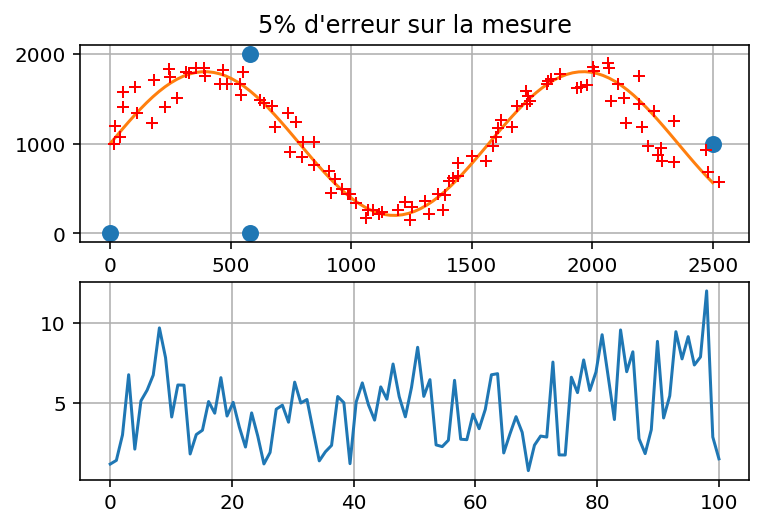

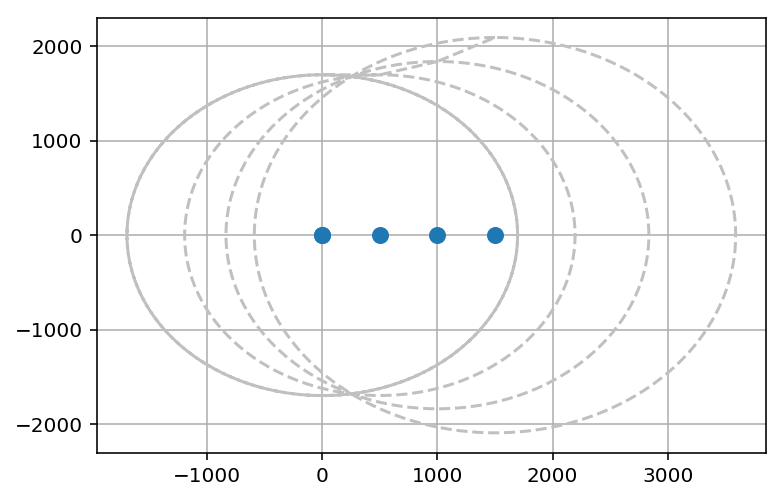

In [11]:
# -*- coding: utf-8 -*-
"""
Created on Thu Jun 14 21:22:03 2018

@author: Sami
"""

import matplotlib.pyplot as plt
from numpy import *
from math import pi
from random import *

class automateSim(object):
    def __init__(self,rate=0.05):
        self.plotNum = 4           #
        self.anchors = []          # [_Xaux,_Yaux]                                       / anchorsPosition() //
        self.ray=[]                # [[R11,,,R1n],...,[Rm1,...,Rmn]]                     / rightPosition()
        self.mray=[]               # [[R11,,,R1n],...,[Rm1,...,Rmn]]                     / distanceSensors()
        self.rate = rate           # 0 < rate < 1                                        / input
        self.mode = 1              # 1,2,3 ?                                             / input
        self.cercles=[]            # [[Cx1,..,Cxn],[Cy1,...,Cyn]] n=720*len(ray[0])      / drawCercles()
        self.robotXY = []          # [[x1,..,xn],[y1,..,yn]]                             / robotMove()
        self.A=[]                  # [[A11,A12],...,[An1,An2]]                           / computeAB() \\ A est unique pour chaque shèma de balises
        self.b=[]                  # [[b11,...,b1n],...,[bm1,...,bmn]] m100,n4           / computeAB()  \\ b est unique pour chaque point du robot
        self.approXY = []          # [[x0,..,xn],[y0,..,yn]]                             / computeAB() -> leastSuareQR() /
        self.error=[[],[],[],[],[],[]]

    def index(self):
        self.robotMove()
        self.rightRayons()
        self.distanceSensors()
        if self.mode ==0:
            print("matrice singuliere")
            plt.grid(True)
            plt.plot(self.anchors[0],self.anchors[1],".",markersize=15)
            mode=1
        else :
            self.computeAB()
            self.leastSquareQR()
            self.err()
            
    def anchorsPosition(self,delta):
        _Xaux=[0,0,delta,delta]
        _Yaux=[0,delta,delta,0]
        self.anchors=[_Xaux,_Yaux]

    def rightRayons(self):
        self.ray=[]

        for k in range(len(self.robotXY[0])):
            auxray=[]
            position=[]
            for i in range(len(self.anchors[1])):
                xyanchor=array((0,0))
                xyanchor[0]=self.anchors[0][i]
                xyanchor[1]=self.anchors[1][i]
                position.append([self.robotXY[0][k],self.robotXY[1][k]])
                auxray.append(linalg.norm(xyanchor-position[i]))
            self.ray.append(auxray)
        

    def distanceSensors(self):
        self.mray=[]
        for k in range(len(self.robotXY[0])):
            auxmray=[]
            for i in range(len(self.anchors[1])):
                auxmray.append(self.ray[k][i]+randint(-int(self.ray[k][i]*self.rate)-1,int(self.ray[k][i]*self.rate+1)))
            self.mray.append(auxmray)
    def computeA(self):
        self.A=[]
        _x=self.anchors[0]
        _y=self.anchors[1]
        A=[]
        for i in range(1,len(_x)):
            A.append([_x[i]-_x[0],_y[i]-_y[0]])
        self.A=A
    def computeAB(self):
        _x=self.anchors[0]
        _y=self.anchors[1]
        self.computeA()
#---
        self.b=[]
        for k in range(len(self.robotXY[0])):
            auxb=[]
            for i in range(1,len(self.mray[0])):
                auxb.append(0.5*(self.mray[k][0]**2-self.mray[k][i]**2+(_x[i]-_x[0])**2+(_y[i]-_y[0])**2))
            
            self.b.append(auxb)
#---
    def leastSquareQR(self):
        x1=[]
        q,r=linalg.qr(self.A)
        rinv=linalg.inv(r)
        qtrns=transpose(q)
        x1=matmul(rinv,qtrns)
        #print(x1) #--------------
        position=[]
        newx=[]
        newy=[]
        self.approXY=[]
        for k in range(len(self.robotXY[0])):
            position.append(matmul(x1,self.b[k]))
            newx.append(position[0][0])
            newy.append(position[0][1])
            position=[]
        
        self.approXY.append(newx)
        self.approXY.append(newy)
        
        

    def robotMove(self):
        t=linspace(0,10,100)
        x=250*t
        y=(1000+800*sin(t))
        self.robotXY.append(x)
        self.robotXY.append(y)

    def drawCercles(self,_R): # _R = mray or ray \\ "test.drawCercles(test.mray)"
        teta=linspace(0,2*pi,720);
        cx=[]
        cy=[]
        for k in range(len(self.anchors[0])):
            for i in range(len(teta)):
                cx.append(self.anchors[0][k]+_R[k]*sin(teta[i]))
                cy.append(self.anchors[1][k]+_R[k]*cos(teta[i]))
        self.cercles=[cx,cy]
        plt.plot(cx,cy,"--",color="silver")
    def err(self):
        self.error=[[],[],[],[],[],[]]
        for j in range(len(self.robotXY[0])):
            distances=0
            position=[]
            position.append(self.robotXY[0][j])
            position.append(self.robotXY[1][j])
            #ray=rightRayons(position,self.anchors)
            #mesuredRay=distanceSensors(self.rate,self.ray)
            for i in range(len(self.mray[0])):
                distances+=self.mray[j][i]
            distances=distances/4
            #approx=computeXY(mesuredRay,vector)
            self.error[0]=linspace(0,len(self.robotXY[0]),len(self.robotXY[0]))
            self.error[1].append(abs(self.robotXY[0][j]-self.approXY[0][j]))
            self.error[2].append(abs(self.robotXY[1][j]-self.approXY[1][j]))
            self.error[3].append(sqrt((self.robotXY[0][j]-self.approXY[0][j])**2 + (self.robotXY[1][j]-self.approXY[1][j])**2))
            self.error[4].append(100*self.error[3][j]/(sqrt((self.robotXY[0][j])**2 + (self.robotXY[1][j])**2)))
            self.error[5].append(100*self.error[3][j]/(distances))
    def plot(self,i,title):
        plt.figure(i)
        plt.subplot(211)
        plt.grid(True)
        plt.title(title)
        plt.plot(self.anchors[0],self.anchors[1],".",markersize=15)
        plt.plot(self.robotXY[0],self.robotXY[1])
        plt.plot(self.approXY[0],self.approXY[1],"+",color="red")
        
        plt.subplot(212)
        plt.grid(True)
        plt.plot(self.error[0],self.error[5],)
        plt.show



test1=automateSim(0.01)
test1.anchorsPosition(1000)
test1.index()
test1.plot(1,title="1% d'erreur sur la mesure")

test2=automateSim(0.05)
test2.anchorsPosition(1000)
test2.index()
test2.plot(2,title="5% d'erreur sur la mesure")

test3=automateSim(0.10)
test3.anchorsPosition(1000)
test3.index()
test3.plot(3,title="10% d'erreur sur la mesure")

test4=automateSim(0.05)
test4.anchors=[[0, 0, 1000, 1000, 2500, 2500], [0, 1800, 0, 1800, 0, 1800]]
test4.index()
test4.plot(4,title="5% d'erreur sur la mesure")


test5=automateSim(0.05)
test5.anchors=[[0,580,580,2500],[0,0,2000,1000]]
test5.index()
test5.plot(5,title="5% d'erreur sur la mesure")

plt.figure(6)
test6=automateSim(0.05)
test6.anchors=[[0,0,500,1000,1500],[0,0,0,0,0]] 
#matrice singulière
test6.mode=0
test6.index()
test6.drawCercles(test6.ray[10])
